# Pipeline for Processing GeneLab RNA-sequencing Data

> **This Jupyter Notebook (JN) was built as a SJSU/GeneLab collaboration to teach students how to process RNA sequencing data using the GeneLab standard pipeline. Below are step-by-step instructions for processing samples derived from the soleus (aka "anti-gravity") muscle of mice that were either flown in space aboard the International Space Station (ISS) (spaceflight, FLT, animals) or kept in an environmental simulator on Earth to serve as ground controls (GC, animals) during NASA's Rodent Research - 1 mission. More information about the samples analyzed here can be found in the [GeneLab Data Repository](https://genelab-data.ndc.nasa.gov/genelab/projects) under [GLDS-104](https://genelab-data.ndc.nasa.gov/genelab/accession/GLDS-104/).**  

---

### Fastq to Counts Workflow

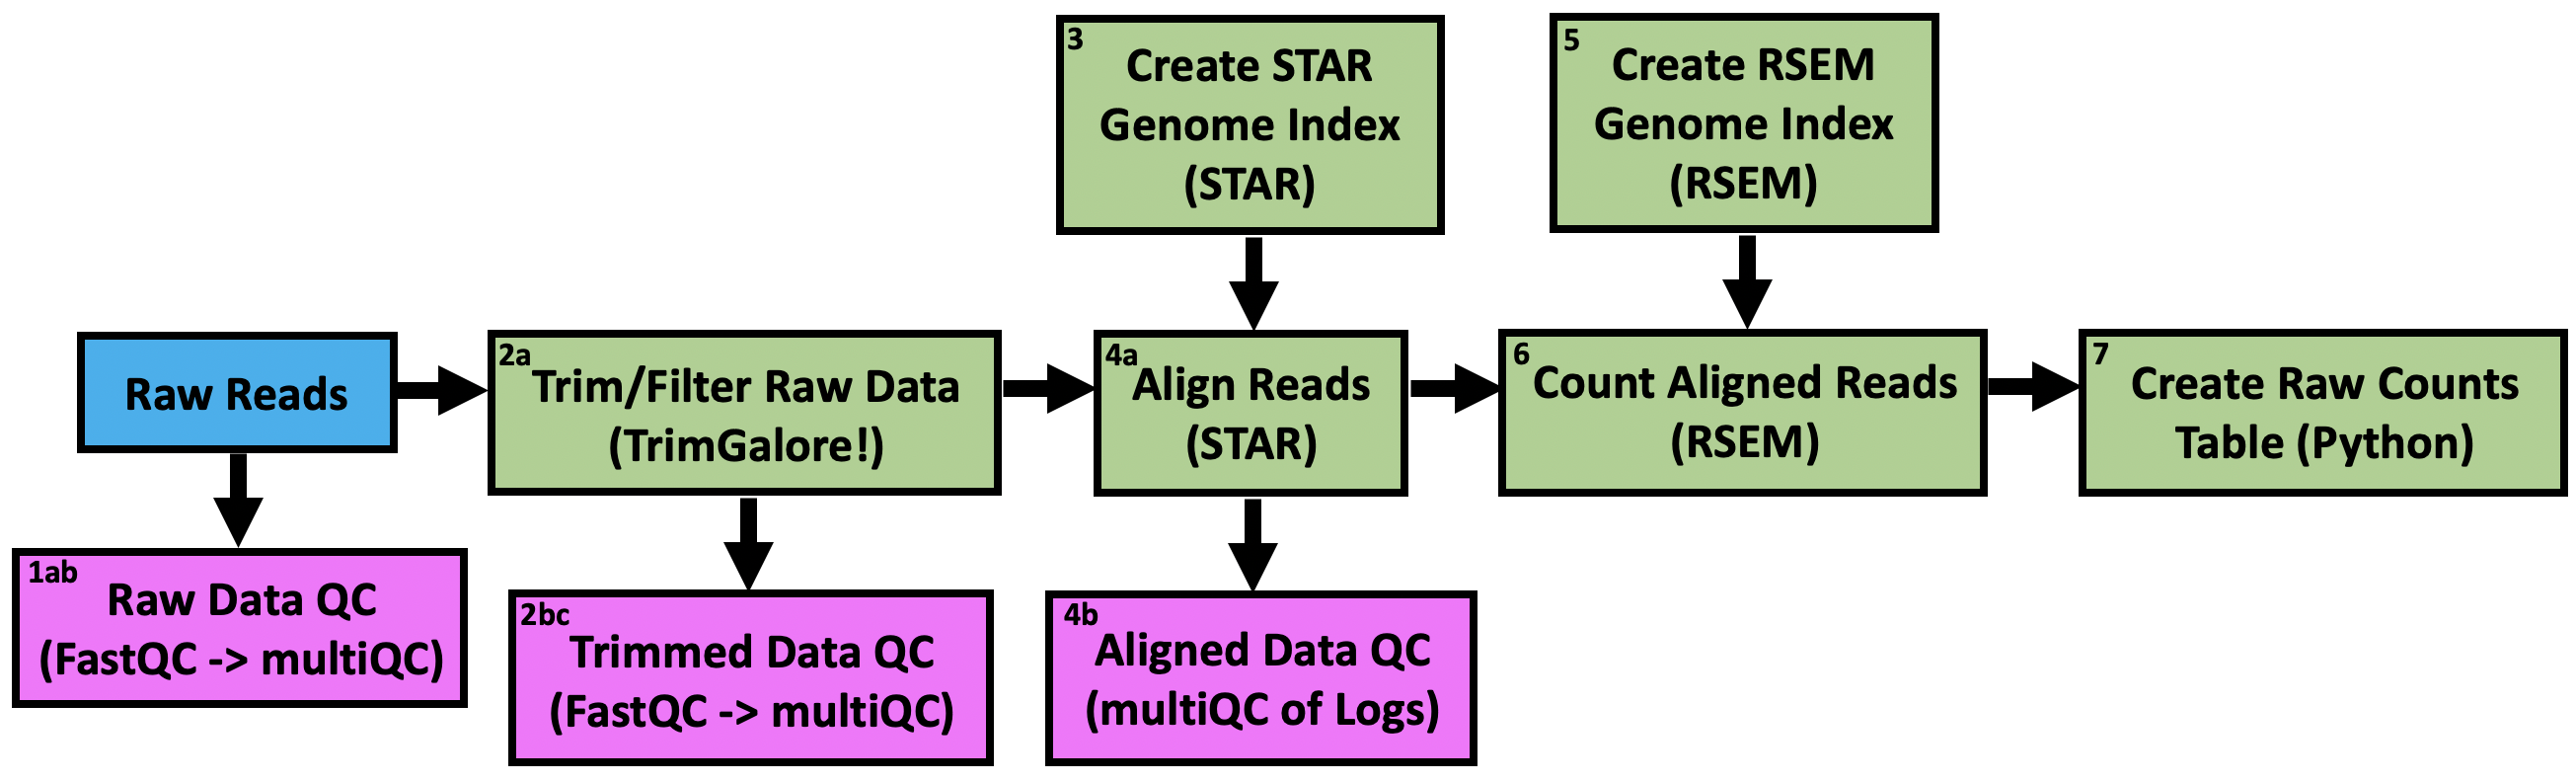

# Table of Contents

* [0. Create Directory Structure for QC and Processed Data](#dirstructure)
* [1. Raw Data Quality Control (QC)](#rawqc)
    * [1a. Raw Data QC with FastQC](#rawfastqc)
    * [1b. Compile Raw Data QC with MultiQC](#rawmultiqc)
* [2. Trim/Filter Raw Data](#trimfilter)
    * [2a. Trim and Filter Raw Sequence Data with Trim Galore!](#trim)
    * [2b. Trimmed Data QC with FastQC](#trimmedfastqc)
    * [2c. Compile Trimmed Data QC with MultiQC](#trimmedmultiqc)
* [3. Build a STAR Index for the Reference Genome](#starindex)
* [4. Align Reads to the Reference Genome with STAR](#star)
    * [4a. Align Trimmed Sequence Data with STAR](#staralign)
    * [4b. Compile Alignment Log Files with MultiQC](#alignmultiqc)
* [5. Build a RSEM Index for the Reference Genome](#rsemindex)
* [6. Count Aligned Reads with RSEM](#rsemcount)
* [7. Generate Raw Counts Table](#counttable)

<a class="anchor" id="dirstructure"></a>

## 0. Create Directory Structure for QC and Processed Data

Before running any analyses, let's create a directory structure to store the data. During RNAseq processing, you will generate several, likely 100s, of files so it is important to keep the QC and processed data files orgainzed.

Let's start by creating a top level directory with the GeneLab dataset number indicated:

In [ ]:
!mkdir ./GLDS-104

The next series of commands will be used to create sub-directories within the GLDS-104 top-level directory we just created (with the command above) to store the data from each step in the RNAseq processing pipeline.

Create sub-directories for raw data quality control:

In [ ]:
!mkdir ./GLDS-104/00-RawData
!mkdir ./GLDS-104/00-RawData/FastQC_Reports
!mkdir ./GLDS-104/00-RawData/FastQC_Reports/raw_multiqc_report

Create sub-directories for trimmed/filtered sequence data and respective quality control data:

In [ ]:
!mkdir ./GLDS-104/01-TG_Preproc
!mkdir ./GLDS-104/01-TG_Preproc/Fastq
!mkdir ./GLDS-104/01-TG_Preproc/FastQC_Reports
!mkdir ./GLDS-104/01-TG_Preproc/FastQC_Reports/trimmed_multiqc_report

Create sub-directories for aligned data and respective quality control data:

In [ ]:
!mkdir ./GLDS-104/02-STAR_Alignment
!mkdir ./GLDS-104/02-STAR_Alignment/aligned_multiqc_report

Create sub-directory for individual, raw count data:

In [ ]:
!mkdir ./GLDS-104/03-RSEM_Counts

Create sub-directories for combined raw and normalized counts tables and PCA data/plots:

In [ ]:
!mkdir ./GLDS-104/04-DESeq2_NormCounts
!mkdir ./GLDS-104/04-DESeq2_NormCounts/PCA

Create sub-directory for differential expression analysis data:

In [ ]:
!mkdir ./GLDS-104/05-DESeq2_DGE
!mkdir ./GLDS-104/05-DESeq2_DGE/DGE_plots

### Define Paths to BioCS123B Processed Data

To save time and conserve resources, some of the processing steps below will utilize processed data that have already been generated for this course. Run the following commands to let the computer know where to find those files:

In [ ]:
raw_fastq="/path/to/pre-generated/data/GLDS-104/00-RawData/Fastq"
raw_fastqc="/path/to/pre-generated/data/GLDS-104/00-RawData/FastQC_Reports"
raw_multiqc="/path/to/pre-generated/data/GLDS-104/00-RawData/FastQC_Reports/raw_multiqc_report"
trimmed_fastq="/path/to/pre-generated/data/GLDS-104/01-TG_Preproc/Fastq"
trim_report="/path/to/pre-generated/data/GLDS-104/01-TG_Preproc/Trimming_Reports"
trimmed_fastqc="/path/to/pre-generated/data/GLDS-104/01-TG_Preproc/FastQC_Reports"
trimmed_multiqc="/path/to/pre-generated/data/GLDS-104/01-TG_Preproc/FastQC_Reports/trimmed_multiqc_report"
genome_gtf="/path/to/pre-generated/data/genomes_gtf/ensembl_101/Mus_musculus"
STAR_index="/path/to/pre-generated/data/STAR_Indices/ensembl_101/Mus_musculus_RL-100"
STAR_output="/path/to/pre-generated/data/GLDS-104/02-STAR_Alignment"
STAR_logs="/path/to/pre-generated/data/GLDS-104/02-STAR_Alignment/Log_files"
aligned_multiqc="/path/to/pre-generated/data/GLDS-104/02-STAR_Alignment/aligned_multiqc_report"
RSEM_index="/path/to/pre-generated/data/RSEM_Indices/ensembl_101/Mus_musculus"
RSEM_output="/path/to/pre-generated/data/GLDS-104/03-RSEM_Counts"
processing="/path/to/pre-generated/data/GLDS-104/processing_scripts"

Okay, now that we're done with our housekeeping, it's time to start processing RNAseq data!

---

<a class="anchor" id="rawqc"></a>

## 1. Raw Data Quality Control (QC)

<a class="anchor" id="rawfastqc"></a>

### 1a. Raw Data QC with FastQC

First, we will assess the quality of the raw RNA sequence data using the [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) program. Short-read sequence data are stored in fastq files, which contain several (often millions) of reads. Each read consists of the following 4 line structure:

 > Line 1 - Begins with @, followed by information about the sequencing run such as the sequencing platform, run number, flow cell ID and cluster location, read number (forward/reverse), and/or the sample index.
 <br>
 > Line 2 - Contains the sequence, written as base calls (A, T, C, or G). Note that the sequence length is equal to the number of cycles in the sequencing run.
 <br>
 > Line 3 - A separator line, which begins with a plus (+) sign.
 <br>
 >Line 4 - Quality scores of each base call that are Phred +33 encoded and use [ASCII characters](http://drive5.com/usearch/manual/quality_score.html) to represent the quality of the bases. 

Example read:

 > @J00113:162:H7W32BBXX:1:1101:9658:1947 1:N:0:GGTGCG
GTCAGTATCATGCTGCGGCTTCAAATCCGAAGTGATGTTTTGATGTGAAGTGAAATTTTAGTTGTCGTAGTAGGCAAACAATAAGGAATGTTGATCCAATAATTACATGGAGTCCAT
+
AAFFFJJJAAAAFAFFAFJAAAFJJJJJFFFJFFFJJFFJJJJJJJJJJJJJJJFJJJJJJJJJJJJJFJJJJJJJFFFJJJFJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJ

FastQC will evaluate the information provided for each read in the fastq files and generate a summary report about the quality of the sequence data. Assessing the raw sequence quality is important for determining if and how the reads need to be trimmed.

Let's run FastQC on the forward read (R1) of one of our FLT samples using the following command:
> Note: To properly allocate compute resources, we will submit this command to a job queue in the next cell.

`!fastqc -o ./GLDS-104/00-RawData/FastQC_Reports $raw_fastq/FLT_Rep1_*_raw.fastq.gz`

**Parameter Definitions:**

* `-o` – the output directory to store the FastQC results
* `*.fastq.gz` – the input reads are specified as a positional argument, and can be given all at once with wildcards like this, or as individual arguments with spaces inbetween them

**Input Data:**
- *raw.fastq.gz (raw reads)

**Output Data:**
- *fastqc.html (FastQC report: a webpage file containing graphical representations of the raw sequence quality)
- *fastqc.zip (FastQC data: a compressed directory containing the quality reports of all raw sequences assessed)

In [ ]:
!sbatch $processing/00-RawData/raw_fastqc_FLT_Rep1.slurm

_____

While our command is running, let's view an example of the standard output from this command:

In [ ]:
!cat $processing/00-RawData/raw_fastqc_out_logs/GLDS-104_raw_fastqc_234215_1.out

___________

Let's view the FastQC report generated:

In [ ]:
# Import libraries for HTML visualization
from IPython.display import IFrame

In [ ]:
IFrame(src='FLT_Rep1_R1_raw_fastqc.html', width=1500, height=2000)

You can comment out the line above using `#` at the beginning of the line, and re-run the cell to hide the FastQC report when you are done.

Let's assess the sequence quality of one more sample. To save time, the FastQC data and reports have been generated for the forward (R1) and reverse (R2) raw fastq files of all GLDS-104 FLT and GC samples. Run the next cell to view the FastQC report for the reverse read data of the same FLT sample. You can comment this line and rerun the cell to hide the output when you are finished viewing the report.

In [ ]:
# Import libraries for HTML visualization
from IPython.display import IFrame

In [ ]:
IFrame(src='FLT_Rep1_R2_raw_fastqc.html', width=1500, height=2000)

<a class="anchor" id="rawmultiqc"></a>

### 1b. Compile Raw Data QC with MultiQC

Rather than viewing the FastQC reports of each fastq file for all 12 samples individually, we can use the [MultiQC](https://multiqc.info/) program to compile the FastQC data from all samples and generate a single report (and associated data files). This allows us to view and assess the raw sequence data of all samples at once. 

Let's compile the raw FastQC data from our 12 samples using MultiQC by running the following command:

In [ ]:
!multiqc -n raw_multiqc -o ./GLDS-104/00-RawData/FastQC_Reports/raw_multiqc_report $raw_fastqc/

**Parameter Definitions:**

* `-n` – prefix name for the output files
* `-o` – the output directory to store the MultiQC results
* `$raw_fastqc/` – the directory holding the raw FastQC data from each sample, provided as a positional argument

**Input Data:**
- *fastqc.zip (FastQC data)

**Output Data:**
- raw_multiqc_data (directory containing the compiled raw FastQC data from each sample, used to create the MultiQC report)
- raw_multiqc.html (multiqc report: an interactive webpage file containing graphical representations of the compiled raw sequence quality)

Let's view the MultiQC report generated from the raw FastQC data:

> Note: Click [here](https://multiqc.info/examples/rna-seq/multiqc_report.html#fastqc) for an example and description of the MultiQC plots derived from FastQC data

In [ ]:
# Import libraries for HTML visualization
from IPython.display import IFrame

In [ ]:
IFrame(src='raw_multiqc.html', width=1200, height=5000)

**Take a look at the multiQC report of the raw fastQC data above and answer the following questions:**

1. Which sample was sequenced at the greatest read depth? the least read depth? (Hint: See *M Seqs* under "General Statistics")
2. What do you notice about the quality of the raw sequence data? Are there any differences between the forward and reverse reads?
2. Were adapters detected?
3. Should we trim and/or filter the data before aligning to the reference genome? Why or why not?

<br>

---

<a class="anchor" id="trimfilter"></a>

## 2. Trim/Filter Raw Data

<a class="anchor" id="trim"></a>

### 2a. Trim and Filter Raw Sequence Data with Trim Galore! 

To ensure maximal sequence alignment to the reference genome, our next step is to clean up the raw sequence data using [TrimGalore!](https://www.bioinformatics.babraham.ac.uk/projects/trim_galore/), which utilizes the [cutadapt](https://cutadapt.readthedocs.io/en/stable/) software. During this step, we filter the raw reads to remove any sequencing adapters detected, which were artificially added to enable sequencing of the sample RNA, as well as low-quality base calls and reads that become too short after trimming.

Any idea why we would want to do this before aligning to the reference genome?

Let's trim the forward (R1) and reverse (R2) reads of one of our FLT samples with TrimGalore! using the following command:

> Note: Since the TrimGalore! command needs more compute resources than FastQC, we will submit this command to a job queue in the next cell.

`!trim_galore --gzip \`   
`--phred33 \`  
`--illumina \`  
`--output_dir ./GLDS-104/01-TG_Preproc/Fastq \`  
`--paired \`  
`$raw_fastq/FLT_Rep1_R1_raw.fastq.gz $raw_fastq/FLT_Rep1_R2_raw.fastq.gz`


**Parameter Definitions:**

* `--gzip` – compress the output files with `gzip`
* `--phred33` - instructs cutadapt to use ASCII+33 quality scores as Phred scores for quality trimming
* `--illumina` - defines the adapter sequence to be trimmed as the first 13bp of the Illumina universal adapter `AGATCGGAAGAGC`
* `--output_dir` - the output directory to store the trimmed fastq and respective trimming report files
* `--paired` - indicates paired-end reads - both reads, forward (R1) and reverse (R2) must pass length threshold or else both reads are removed (if not defined, a 20bp length threshold is applied)
* `$raw_fastq/FLT_Rep1_R1_raw.fastq.gz $raw_fastq/FLT_Rep1_R2_raw.fastq.gz` – the input reads are specified as a positional argument, paired-end read files are listed pairwise such that the forward reads (\*R1_raw.fastq.gz) are immediately followed by the respective reverse reads (\*R2_raw.fastq.gz) for each sample

**Input Data:**
- *raw.fastq.gz (raw reads)

**Output Data:**
- *trimmed.fastq.gz (trimmed reads: remainig sequence data after quality, adapter, and read length filtering)
- *trimming_report.txt (trimming report: information about how the data were trimmed/filtered)

In [ ]:
!sbatch $processing/01-TG_Preproc/trim-galore_FLT_Rep1.slurm

____

While our command is running, let's view an example of the trimming report for the **forward** read data (R1) from the sample we trimmed/filtered with TrimGalore!

In [ ]:
!cat $trim_report/FLT_Rep1_R1_raw.fastq.gz_trimming_report.txt

____

Now, let's take a look at an example of the trimming report for the **reverse** read data (R1) from the sample we trimmed/filtered with TrimGalore:

In [ ]:
!cat $trim_report/FLT_Rep1_R2_raw.fastq.gz_trimming_report.txt

____

**Take a look at the === Summary === section of both the forward and reverse read trimming reports and answer the following questions:**

1. How many forward reads were processed? 
2. How many reverse reads were processed? 
3. Are the total number of forward and reverse reads processed the same or different? Should these numbers be the same? Why? 
4. Were any adapters detected in the forward or reverse reads? If yes, how many forward reads contained adapters? How many reverse reads contained adapters? Are these numbers the same or different?
5. After adapters were trimmed from the forward and reverse reads, were any reads removed? Why?
6. How many basepairs were remove due to poor quality in the forward reads? What about the reverse reads?
7. After filtering basepairs for quality, what percent of basepairs were removed from the forward reads? What about the reverse reads?
8. Did the raw forward or raw reverse reads have better quality? How do you know?

**Look at the bottom of the reverse read trimming report and answer the following questions:**

9. After trimming and filtering, did any read pairs fail to meet the 20bp read length cutoff? If yes, how many?
10. Why is this information only contained in the reverse read trimming report?


Note: To save time, raw sequence data for all samples have been trimmed with these parameters and the resulting trimmed reads will be used for the following steps.

<br>

<a class="anchor" id="trimmedfastqc"></a>

### 2b. Trimmed Data QC with FastQC

Now that we've trimmed/filtered our raw sequence data, we will assess the quality of the trimmed sequence data using [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) to evaluate how effective trimming was at improving sequence quality.

Let's run FastQC on the forward read (R1) of one of our trimmed FLT samples using the following command:

> Note: To properly allocate compute resources, we will submit this command to a job queue in the next cell.

`!fastqc -o ./GLDS-104/01-TG_Preproc/FastQC_Reports $trimmed_fastq/FLT_Rep1_R1_trimmed.fastq.gz`

**Parameter Definitions:**

* `-o` – the output directory to store the FastQC results
* `*.fastq.gz` – the input reads are specified as a positional argument, and can be given all at once with wildcards like this, or as individual arguments with spaces inbetween them

**Input Data:**
- *trimmed.fastq.gz (trimmed reads)

**Output Data:**
- *fastqc.html (FastQC report: a webpage file containing graphical representations of the trimmed sequence quality)
- *fastqc.zip (FastQC data: a compressed directory containing the quality reports of all trimmed sequences assessed)


To save time, the FastQC data and reports have been generated for the forward (R1) and reverse (R2) trimmed fastq files of all GLDS-104 FLT and GC samples. 

In [ ]:
!sbatch $processing/01-TG_Preproc/trimmed_fastqc_FLT_Rep1.slurm

______

While our command is running, let's view an example of the standard output from this command:

In [ ]:
!cat $processing/01-TG_Preproc/trimmed_fastqc_out_logs/GLDS-104_trimmed_fastqc_234257_1.out

<a class="anchor" id="trimmedmultiqc"></a>

### 2c. Compile Trimmed Data QC with MultiQC

Rather than viewing the FastQC reports of each trimmed fastq file for all 12 samples individually, we'll again use the [MultiQC](https://multiqc.info/) program but this time to compile the trimmed FastQC data from all samples and generate a single report (and associated data files). This will allow us to view the trimmed sequence data quality of all samples at once and compare it to the raw sequence data quality. 

Let's compile the trimmed FastQC data from our 12 samples using MultiQC by running the following command:

In [ ]:
!multiqc -n trimmed_multiqc -o ./GLDS-104/01-TG_Preproc/FastQC_Reports/trimmed_multiqc_report $trimmed_fastqc/

**Parameter Definitions:**

* `-n` – prefix name for the output files
* `-o` – the output directory to store the MultiQC results
* `$trimmed_fastqc/` – the directory holding the trimmed FastQC data from each sample, provided as a positional argument

**Input Data:**
- *fastqc.zip (trimmed FastQC data)

**Output Data:**
- trimmed_multiqc_data (directory containing the compiled trimmed FastQC data from each sample, used to create the MultiQC report)
- trimmed_multiqc.html (multiqc report: an interactive webpage file containing graphical representations of the compiled trimmed sequence quality)

Let's view the MultiQC report generated from the trimmed FastQC data:

> Note: Click [here](https://multiqc.info/examples/rna-seq/multiqc_report.html#fastqc) for an example and description of the MultiQC plots derived from FastQC data

In [ ]:
# Import libraries for HTML visualization
from IPython.display import IFrame

In [ ]:
IFrame(src='trimmed_multiqc.html', width=1200, height=5000)

___

**Take a look at the multiQC report of the trimmed fastQC data above and answer the following questions:**

1. How many reads are there in the GC_Rep1 sample after trimming? What about the FLT_Rep2 sample? Are they still the samples sequenced at the greatest and least read depth, respectively? (Hint: See *M Seqs* under "General Statistics")
2. What is the sequencing depth range among samples? Is this an issue? 
3. What do you notice about the quality of the trimmed sequence data compared with the raw?
4. Do you still see adapters detected?
5. Do you think we're ready to align the trimmed reads to the reference genome now? Why or why not?

<br>

---

<a class="anchor" id="starindex"></a>

## 3. Build a STAR Index for the Reference Genome

Now that our RNA sequence data is of high quality, our next step is to identify which gene(s) each RNA sequence came from. To do this, we will align the reads back to the reference genome of the organism from which the samples were derived using the [STAR (Spliced Transcripts Alignment to a Reference)](https://github.com/alexdobin/STAR) aligner. 

Since our samples came from the soleus muscle of mice (scientific name _Mus musculus_), we will align the trimmed reads to the _Mus musculus_ reference genome (GRCm38.p6) from the ensembl database found [here](ftp://ftp.ensembl.org/pub/release-101/fasta/mus_musculus/dna/Mus_musculus.GRCm38.dna.primary_assembly.fa.gz). In addition to the reference genome, we will also need to provide STAR with information about the gene features of all annotated genes in the reference genome. (Note: Annotated genes are genes whose genomic coordinatates and function, i.e. where they are and what they do, are known.) All of the gene feature information STAR needs is provided in the gene transfer format (GTF) file associated with the _Mus musculus_ reference genome (GRCm38.p6) from the ensembl database found [here](ftp://ftp.ensembl.org/pub/release-101/gtf/mus_musculus/Mus_musculus.GRCm38.101.gtf.gz).

> For more information about the ensembl gene transfer format (GTF) and gene feature format (GFF) files, click [here](http://m.ensembl.org/info/website/upload/gff.html)

Before we can align our trimmed reads to the _Mus musculus_ reference genome, the STAR program needs to organize all the information provided in the genome and GTF files to be able to accurately assign each read to the gene from which it came. To do this, we will first run STAR in the `genomeGenerate` mode, which will create a STAR index containing the genome reference and gene feature information in the STAR format. 

\*Note: Creating a STAR index requires a lot of compute and storage resources and can take a while to complete, so we did it for you. You're welcome :0)

The following command was used to generate the STAR index for _Mus musculus_:

`!STAR --runThreadN 15 \`  
`--runMode genomeGenerate \`  
`--limitGenomeGenerateRAM 50000000000 \`  
`--genomeSAindexNbases 14 \`  
`--genomeDir $STAR_index \`  
`--genomeFastaFiles $genome_gtf/Mus_musculus.GRCm38.dna.primary_assembly.fa \`  
`--sjdbGTFfile $genome_gtf/Mus_musculus.GRCm38.101.gtf \`  
`--sjdbOverhang 99`  

**Parameter Definitions:**

* `--runThreadN` – number of threads available on server node to create the STAR indexed reference
* `--runMode` - instructs STAR to run genome indices generation job to create the STAR indexed reference
* `--limitGenomeGenerateRAM` - maximum RAM available (in bytes) to generate STAR reference; at least 35GB are needed for mouse and the example above shows 50GB
* `--genomeSAindexNbases` - length (in bases) of the SA pre-indexing string, usually between 10 and 15. Longer strings require more memory but allow for faster searches. This value should be scaled down for smaller genomes (like bacteria) to min(14, log2(GenomeLength)/2 - 1). For example, for a 1 megaBase genome this value would be 9.
* `--genomeDir` - specifies the path to the directory where the STAR indexed reference will be stored. At least 100GB of available disk space is required for mammalian genomes.
* `--genomeFastaFiles` - specifies one or more uncompressed fasta file(s) containg the genome reference sequences
* `--sjdbGTFfile` – specifies the uncompressed file(s) containing annotated transcripts in the standard gtf format
* `--sjdbOverhang` - indicates the length of the genomic sequence around the annotated junction to be used in constructing the splice junctions database. The length should be one less than the length of the reads.

**Input Data:**
- *.fasta (genome sequence)
- *.gtf (genome transfer feature file)

**Output Data:**

STAR indexed genome reference, which consists of the following files:
- chrLength.txt
- chrNameLength.txt
- chrName.txt
- chrStart.txt
- exonGeTrInfo.tab
- exonInfo.tab
- geneInfo.tab
- Genome
- genomeParameters.txt
- SA
- SAindex
- sjdbInfo.txt
- sjdbList.fromGTF.out.tab
- sjdbList.out.tab
- transcriptInfo.tab

<br>

---

<a class="anchor" id="star"></a>

## 4. Align Reads to the Reference Genome with STAR

<a class="anchor" id="staralign"></a>

### 4a. Align Trimmed Sequence Data with STAR

We are now ready to align the trimmed reads to the mouse reference genome. This step of determining the genomic location (and ultimately, gene) from which each short sequence was derived is quite challenging. Any ideas why that is?

- Reads are very short relative to transcripts, and some genomes (including mouse and human) can be quite large and contain lots of non-unique sequences such as pseudogenes, which makes mapping difficult. 
- Aligners also have to cope with mismatches and indels (insertions and deletions) caused by genomic variation and sequencing errors. 
- Many organisms have introns in their genes and therefore, reads align non-contiguously (not touching). Placing spliced reads across introns and determining exon-intron boundaries is difficult, especially considering that introns can be thousands of base pairs long.

Spliced aligners, including STAR, were developed to more accurately identify non-contiguously aligned reads. Additionally, the STAR spliced alignment program is able to perform an unbiased search for splice junctions without needing any prior information on location, sequence signals, or intron length. It is also capable of aligning a read with multiple splice junctions, indels and mismatches and those with low-quality ends.

In order to improve the detection and quantification of splice sites, we will run STAR in the “two-pass mode”. Here, splice sites are detected in the initial mapping to the reference and used to build a new reference that includes these splice sites. Reads are then re-mapped to this dynamically generated reference to improve the quantification of splice isoforms.

Let's align the trimmed forward (R1) and reverse (R2) reads of one of our FLT samples with STAR using the following command:

> Note: Since the STAR command requires a lot of compute resources, we will submit this command to a job queue in the next cell.

`STAR --twopassMode Basic \`  
`--limitBAMsortRAM 55000000000 \`  
`--genomeDir $STAR_index \`  
`--outSAMunmapped Within \`  
`--outFilterType BySJout \`  
`--outSAMattributes NH HI AS NM MD MC \`  
`--outFilterMultimapNmax 20 \`  
`--outFilterMismatchNmax 999 \`  
`--outFilterMismatchNoverReadLmax 0.04 \`  
`--alignIntronMin 20 \`  
`--alignIntronMax 1000000 \`  
`--alignMatesGapMax 1000000 \`  
`--alignSJoverhangMin 8 \`  
`--alignSJDBoverhangMin 1 \`  
`--sjdbScore 1 \`  
`--readFilesCommand zcat \`  
`--runThreadN 15 \`  
`--outSAMtype BAM SortedByCoordinate \`  
`--quantMode TranscriptomeSAM \`  
`--outSAMheaderHD @HD VN:1.4 SO:coordinate \`  
`--outFileNamePrefix ./GLDS-104/02-STAR_Alignment/FLT_Rep1_ \`  
`--readFilesIn $trimmed_fastq/FLT_Rep1_R1_trimmed.fastq.gz $trimmed_fastq/FLT_Rep1_R2_trimmed.fastq.gz`  


**Parameter Definitions:**

* `--twopassMode` – specifies 2-pass mapping mode; the `Basic` option instructs STAR to perform the 1st pass mapping, then automatically extract junctions, insert them into the genome index, and re-map all reads in the 2nd mapping pass
* `--limitBAMsortRAM` - maximum RAM available (in bytes) to sort the bam files, the example above indicates 55GB
* `--genomeDir` - specifies the path to the directory where the STAR indexed reference is stored
* `--outSAMunmapped` - specifies ouput of unmapped reads in the sam format; the `Within` option instructs STAR to output the unmapped reads within the main sam file
* `--outFilterType` - specifies the type of filtering; the `BySJout` option instructs STAR to keep only those reads that contain junctions that passed filtering in the SJ.out.tab output file
* `--outSAMattributes` - list of desired sam attributes in the order desired for the output sam file; sam attribute descriptions can be found [here](https://samtools.github.io/hts-specs/SAMtags.pdf)
* `--outFilterMultimapNmax` – specifies the maximum number of loci the read is allowed to map to; all alignments will be output only if the read maps to no more loci than this value
* `--outFilterMismatchNmax` - maximum number of mismatches allowed to be included in the alignment output
* `--outFilterMismatchNoverReadLmax` - ratio of mismatches to read length allowed to be included in the alignment output; the `0.04` value indicates that up to 4 mismatches are allowed per 100 bases
* `--alignIntronMin` - minimum intron size; a genomic gap is considered an intron if its length is equal to or greater than this value, otherwise it is considered a deletion
* `--alignIntronMax` - maximum intron size
* `--alignMatesGapMax` - maximum genomic distance (in bases) between two mates of paired-end reads; this option should be removed for single-end reads
* `--alignSJoverhangMin` - minimum overhang (i.e. block size) for unannotated spliced alignments
* `--alignSJDBoverhangMin` - minimum overhang (i.e. block size) for annotated spliced alignments
* `--sjdbScore` - additional alignment score for alignments that cross database junctions
* `--readFilesCommand` - specifies command needed to interpret input files; the `zcat` option indicates input files are compressed with gzip and zcat will be used to uncompress the gzipped input files
* `--runThreadN` - indicates the number of threads to be used for STAR alignment and should be set to the number of available cores on the server node
* `--outSAMtype` - specifies desired output format; the `BAM SortedByCoordinate` options specify that the output file will be sorted by coordinate and be in the bam format
* `--quantMode` - specifies the type(s) of quantification desired; the `TranscriptomeSAM` option instructs STAR to output a separate sam/bam file containing alignments to the transcriptome
* `--outSAMheaderHD` - indicates a header line for the sam/bam file
* `--outFileNamePrefix` - specifies the path to and prefix for the output file names; for GeneLab the prefix is the sample id
* `--readFilesIn` - path to input read 1 (forward read) and read 2 (reverse read); for paired-end reads, read 1 and read 2 should be separated by a space; for single-end reads only read 1 should be indicated 


**Input Data:**
- STAR indexed reference genome (output from Step 3)
- *fastq.gz (trimmed reads)

**Output Data:**

> Note: Detailed descriptions of all STAR output files can be found in the [STAR manual](https://github.com/alexdobin/STAR/blob/master/doc/STARmanual.pdf) under the "Output files" section.

- *Aligned.sortedByCoord.out.bam (binary, alignment map containg reads mapping to genome, sorted by coordinate)
- *Aligned.toTranscriptome.out.bam (binary, alignment map containg sorted reads mapping to transcriptome)
- *Log.final.out (log file conting a summary of the mapping info/stats such as # reads mapped, etc)
- *Log.out (log file contining detailed information about the mapping run, useful for troubleshooting)
- *Log.progress.out (file containing the job progress statistics that is updated every minute during the mapping run)
- *SJ.out.tab (tab-deliminted file containg identified splice junctions and respective count data)
- *_STARgenome (directory containing the extracted junctions from the 1st pass mapping that was inserted into the genome index)
  - sjdbInfo.txt
  - sjdbList.out.tab
- *_STARpass1 (directory containing splice junction and summary mapping info/stats from the 1st pass mapping)
  - Log.final.out
  - SJ.out.tab
- *_STARtmp (directory containing subdirectories that are empty – this was the location for temp files that were automatically removed after successful completion)
  - BAMsort

In [ ]:
!sbatch $processing/02-STAR_Alignment/STAR_align_FLT_Rep1.slurm

While our command is running, let's view an example of the standard output from this command:

In [ ]:
!cat $processing/02-STAR_Alignment/STAR_align_out_logs/GLDS-104_STAR_align_234269_1.out

___

**Look at the standard output from STAR above and answer the following questions:**

1. Did the STAR alignment complete successfully? How do you know?
2. How long did it take for the STAR alignment to complete? 

___

Let's take a look at the first few lines of an output *Aligned.toTranscriptome.out.bam file using the following command:

*Note: BAM files are compressed, binary versions of Sequence Alignment/Map (SAM) files and need to be uncompressed using `samtools view` to view the file contents.

In [ ]:
!samtools view $STAR_output/FLT_Rep1/FLT_Rep1_Aligned.toTranscriptome.out.bam | head

All BAM/SAM files contain at least the following 11 tab-separated fields in order of column location:

1) **QNAME** - Query template name: Info about the sequencing run that generated the read, found in line 1 of the trimmed fastq file as described in [Step 1a](#rawfastqc) above. 

2) **FLAG** - bitwise FLAG: Information about the alignment encoded in bits. To easily decode the SAM FLAG, type it into the Broad Institute's SAM FLAG decoder [here](https://broadinstitute.github.io/picard/explain-flags.html)

3) **RNAME** - Reference sequence name: Name of the reference sequence the read aligned to (this will be the ensembl transcript ID in the transcript-aligned BAM file as shown above, and the chromosome number in the genome-aligned BAM file)

4) **POS** - 1-based leftmost mapping position: The position on the reference genome in which the left most base of the read aligns.

5) **MAPQ** - Mapping quality: Equality to the -10log(base10) of the probability that the mapping position is wrong; a value of 255 indicates that the mapping quality is not available.

6) **CIGAR** - CIGAR string: Aligned read length and associated operation, which encodes information about the alignment relative to the reference (i.e. match/mismatch, insertion/deletion).

7) **RNEXT** - Reference name of the mate/next read: Reference sequence name of the next aligned read in the template, if it's the same, this is represented with an equal (=) sign.

8) **PNEXT** - Position of the mate/next read: 1-based position of the next aligned read in the template.

9) **TLEN** - Observed template length: Length from the leftmost position of read 1 to the rightmost position of read 2 for aligned paired-end sequence data.

10) **SEQ** - Segment sequence: Sequence of the aligned trimmed read, found in line 2 of the trimmed fastq file as described in [Step 1a](#rawfastqc) above.

11) **QUAL** - ASCII of Phred-scaled base quality +33: Base call quality scores, found in line 4 of the trimmed fastq file as described in [Step 1a](#rawfastqc) above.

12+) Additional SAM attributes that were added with the `--outSAMattributes` option in the STAR alignment command above.

> Detailed descriptions of the Sequence Alignment/Map (SAM) format specification can be found [here](https://samtools.github.io/hts-specs/SAMv1.pdf).

**Now that you know what the fields mean, look at the BAM file above and answer the following questions:** 

1. How many transcripts are represented in the BAM file? How do you know?
2. How many read pairs are shown? How do you know?
3. How many reads align in the same orientation relative to the reference? What about in the opposite orientation? How to you know? 
4. What are the min and max template length shown? How do you know?

Now let's take a look at the the \*Log.final.out file to evaluate trimmed read alignment in one of our FLT samples by running the following command: 

In [ ]:
!cat $STAR_output/FLT_Rep1/FLT_Rep1_Log.final.out

**Use the alignment log file above to answer the following questions:**

1. How many reads mapped to a unique location on the reference genome?
2. How many reads mapped to multiple locations on the reference genome?
3. Were any splice regions identified? If so, how many in total?
4. How many of the spliced regions were annotated? How many were non-canonical?

<a class="anchor" id="alignmultiqc"></a>

### 4b. Compile Alignment Log Files with MultiQC

Rather than viewing the Log.final.out file for all 12 aligned samples individually, we'll again use the [MultiQC](https://multiqc.info/) program to compile the summary alignment info/stats from all samples and generate a single report (and associated data files). This will allow us to view the alignment statistics of all samples at once. 

Let's compile the data in the Log.final.out files from our 12 samples using MultiQC by running the following command:

In [ ]:
!multiqc -n align_multiqc -o ./GLDS-104/02-STAR_Alignment/aligned_multiqc_report $STAR_logs/

**Parameter Definitions:**

* `-n` – prefix name for the output files
* `-o` – the output directory to store the MultiQC results
* `$STAR_logs/` – the directory holding the summary alignment info/stats data from each sample, provided as a positional argument

**Input Data:**
- *Log.final.out (summary alignment info/stats data)

**Output Data:**
- align_multiqc_data (directory containing the compiled summary alignment info/stats data from each sample, used to create the MultiQC report)
- align_multiqc.html (multiqc report: an interactive webpage file containing graphical representations of the compiled alignment info/stats data)

Let's view the MultiQC report generated from the summary alignment info/stats data:

> Note: Click [here](https://multiqc.info/examples/rna-seq/multiqc_report.html#fastqc) for an example and description of the MultiQC plots derived from FastQC data

In [ ]:
# Import libraries for HTML visualization
from IPython.display import IFrame

In [ ]:
IFrame(src='aligned_multiqc.html', width=1200, height=1700)

**Take a look at the multiQC report of the alignment data above and answer the following questions:**

1. What are the min and max % uniquely aligned reads for all samples?
2. What are the min and max % of aligned reads that map to multiple locations?

<br>

---

<a class="anchor" id="rsemindex"></a>

## 5. Build a RSEM Index for the Reference Genome

The next step is to quantify the number of reads that align to each transcript with the [RSEM](https://deweylab.github.io/RSEM/) (RNA-Seq by Expectation-Maximization) transcript quantification method. 

In order to interpret the information provided in the BAM file generated during alignment, the RSEM program first requires the generation of an RSEM index using the reference genome and associated GTF files from the sample organism (similar to STAR). To do this, we will first run the RSEM `rsem-prepare-reference` program, which will extract reference transcripts from the mouse genome using the gene transfer file to create a RSEM indexed reference.  

\*Note: To save time and storage space, we created the RSEM index for you. You're welcome :0)

The following command was used to generate the RSEM index for _Mus musculus_:

`!rsem-prepare-reference --gtf $genome_gtf/Mus_musculus.GRCm38.101.gtf \`  
`$genome_gtf/Mus_musculus.GRCm38.dna.primary_assembly.fa \`  
`$RSEM_index/Mmus`  

**Parameter Definitions:**

* `--gtf` – specifies the uncompressed file(s) containg annotated transcripts in the standard gtf format
* `$genome_gtf/Mus_musculus.GRCm38.dna.primary_assembly.fa` – specifies one or more uncompressed fasta file(s) containg the genome reference sequences, provided as a positional argument
* `$RSEM_index/Mmus` - specifies the path to the directory where the RSEM reference will be stored and the prefix desired for the RSEM reference files (Mmus), provided as a positional argument 

**Input Data:**
- *.fasta (genome sequence)
- *.gtf (genome transfer feature file)

**Output Data:**

RSEM indexed genome reference, which consists of the following files:
- Mmus.chrlist
- Mmus.grp
- Mmus.idx.fa
- Mmus.n2g.idx.fa
- Mmus.seq
- Mmus.ti
- Mmus.transcripts.fa

<br>

---

<a class="anchor" id="rsemcount"></a>

## 6. Count Aligned Reads with RSEM

Now we're ready to quantify the aligned reads with RSEM. Similar to read alignment, quantifying the number of reads that aligned to each gene can also be quite challenging. How so?

If a read maps to more than one location on the genome, how do we know from which location it truly originated? It is also difficult to quantify alternative splice isoforms of a gene with significant sequence overlap. The RSEM software package was designed to address these issues and "rescue" reads that are not uniquely mapped by allocating them to transcripts using a 3-step algorithm:

 1. Estimate abundances based on uniqely mapped reads only.
 2. For each read that maps to multiple locations (multiread), divide it between the transcripts to which it maps, proportional to their abundances estimated in the first step.
 3. Compute abundances based on updated counts for each transcript.

Therefore, we will use RSEM to quantify the aligned reads, due to its ability to account for reads that map to multiple transcripts and distinguish gene isoforms. 

Let's estimate gene and isoform expression levels for one of our samples using the following RSEM command: (Full information on this command is available in the [RSEM user guide](http://deweylab.biostat.wisc.edu/rsem/rsem-calculate-expression.html))

> Note: To properly allocate compute resources, we will submit this command to a job queue in the next cell.

`!rsem-calculate-expression --num-threads 6 \`  
`--alignments \`  
`--bam \`  
`--paired-end \`  
`--seed 12345 \`  
`--estimate-rspd \`  
`--no-bam-output \`  
`--strandedness reverse \`  
`$STAR_output/FLT_Rep1/FLT_Rep1_Aligned.toTranscriptome.out.bam \`  
`$RSEM_index/Mmus \`  
`./GLDS-104/03-RSEM_Counts/FLT_Rep1`  

**Parameter Definitions:**

* `--num-threads` – specifies the number of threads to use
* `--alignments` - indicates that the input file contains alignments in sam, bam, or cram format
* `--bam` - specifies that the input alignments are in bam format
* `--paired-end` - indicates that the input reads are paired-end reads
* `--seed` - the seed for the random number generators used in calculating posterior mean estimates and credibility intervals; must be a non-negative 32-bit integer
* `--estimate-rspd` - instructs RSEM to estimate the read start position distribution (rspd) from the data 
* `--no-bam-output` - instructs RSEM not to output any bam file
* `--strandedness` - defines the strandedness of the RNAseq reads; the `reverse` option means all reads are derived from the reverse strand, which should be used for Illumina TruSeq Stranded protocols
* `$STAR_output/FLT_Rep1/FLT_Rep1_Aligned.toTranscriptome.out.bam` - specifies path to input bam file(s), provided as a positional argument
* `$RSEM_index/Mmus` - specifies the path to the directory where the RSEM reference is stored and its prefix, provided as a positional argument
* `./GLDS-104/03-RSEM_Counts/FLT_Rep1` – specifies the path to and prefix for the output file names; for GeneLab the prefix is the sample id

**Input Data:**
- RSEM genome reference (output from Step 5)
- *Aligned.toTranscriptome.out.bam (binary, alignment map containg sorted reads mapping to transcriptome, output from Step 4)

**Output Data:**
- *genes.results (expression estimates per gene)
- *isoforms.results (expression estimates per isoform)
- *stat (directory containing the following stats files)
	- *cnt
	- *model
	- *theta

In [ ]:
!sbatch $processing/03-RSEM_Counts/rsem_count_FLT_Rep1.slurm

___

While our command is running, let's view an example of the standard output from this command (it is very long, so you may want to comment this cell and re-run it once you are done viewing the output):

In [ ]:
!cat $processing/03-RSEM_Counts/rsem_count_out_logs/GLDS-104_rsem_count_234907_1.out

* You probably saw many lines with messages like this: `Warning: Read J00113:162:H7W32BBXX:1:2205:32065:27443 is ignored due to at least one of the mates' length < seed length (= 25)!` What does this warning mean? (Hint: take a look at the RSEM user guide linked above.) Should we be concerned about this warning?

Let's take a look at the first few lines of an output *genes.results file using the following command:

In [ ]:
!head $RSEM_output/FLT_Rep1.genes.results

The primary output of RSEM consists of two files, one for isoform-level estimates (\*isoforms.results), and the other for gene-level estimates (\*genes.results). Each file consists of gene and transcript ids and lengths, and abundance estimates given in different measures. In the *genes.results files, you'll find the following tab-separated fields in order of column location:

1) **gene_id**: Gene name according to the database used (in this example, we used ensembl genome and GTF files, so the gene names are ensembl IDs). 

2) **transcript_id(s)**: Comma-separated list of all the transcripts derived from the respective gene in column 1.

3) **length**: The weighted average of the respective gene's transcripts' lengths.

4) **effective_length**: The weighted average of the respective gene's transcripts' effective lengths, which are weighted by each transcript's isoform percentage.

5) **expected_count**: The sum of the estimates of the number of read fragments that are derived from each transcript of the respective gene (we will use these count values to calculate differential expression).

6) **TPM**: Transcripts per million, which is a relative measure of transcript abundance - this value is summed over all transcripts for each respective gene to generate the gene TPM value.

7) **FPKM**: Fragments Per Kilobase of transcript per Million mapped reads, which is another relative measure of transcript abundance - this value is summed over all transcripts for each respective gene to generate the gene FPKM value.


> Detailed descriptions of all RSEM output files can be found [here](http://deweylab.biostat.wisc.edu/rsem/rsem-calculate-expression.html#output).

**Now that you know what the fields mean, look at the FLT_Rep1.genes.results file above and answer the following questions:** 

1. What is the first gene listed?

2. For that first gene,

   a. What is the gene length?
   
   b. What is the expected count? 
   
   c. What is the TPM value?  
    
3. What are those values for the third gene listed?

**Extra:**

Take a look at the first few lines of the \*isoforms.results file for the same sample as above using the following command:

In [ ]:
!head $RSEM_output/FLT_Rep1.isoforms.results

___

**Look at the FLT_Rep1.isoforms.results file above and answer the following questions:** 

1. Calculate the sum of the expected count values for all isoforms associated with this gene: ENSMUSG00000000028.
2. How does that value compare with the expected count for gene ENSMUSG00000000028 in the FLT_Rep1.genes.results file?

<a class="anchor" id="counttable"></a>

## 7. Generate Raw Counts Table

We currently have expected counts values for all genes for each sample in their respective *gene.results files calculated in step 6 above. Our next step is to combine the expected gene counts of each sample into one counts table.

To do this, we will run the following set of commands, which use the Python package [pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide).

In [ ]:
## Create raw counts table from RSEM gene counts of each sample ##

# Import python libraries
import pandas as pd
import os

# Define the paths to directories containing metadata and RSEM *genes.results files
metadata_dir="/gpfs/scratch/asbutler/BioCS123B/GLDS-104/Metadata"
counts_dir="./GLDS-104/03-RSEM_Counts"
input_counts_dir="/gpfs/scratch/asbutler/BioCS123B/GLDS-104/03-RSEM_Counts"

# Read in metadata
meta = pd.read_csv(metadata_dir+"/GLDS-104_Group_Metadata.csv")

# Create empty dataframe, assign column names from metadata
counts = pd.DataFrame(columns = meta["sample"])

# Iterate through the *genes.results files, filling in columns with expected_count from each sample
for f in os.listdir(input_counts_dir):
    if f.endswith(".genes.results"):
        counts[f.split(".")[0]] = pd.read_csv(os.path.join(input_counts_dir,f), sep='\t')["expected_count"]

# Add gene names to the first column of our counts table
counts.index = pd.read_csv(input_counts_dir+"/FLT_Rep1.genes.results", sep="\t")["gene_id"]

# Write out unnormalized counts data to a .CSV file
counts.to_csv(counts_dir+"/GLDS-104_Unnormalized_Counts.csv",header=True,index_label="")

Let's view the top 5 rows of our new raw counts table using the pandas command, `.head()`. Note: this table holds genes as rows, and samples as columns. 

In [ ]:
counts.head()

**Look at the beginning of the Unnormalized Counts table above and answer the following questions:**

1. How many genes are shown?
2. Which of the genes shown are not expressed in any sample? 
3. Which sample has the most reads aligning to gene, ENSMUSG00000000028? Which sample has the least?

___

We now have a table containing the raw counts for all genes for all samples in our study (GLDS-104). We will use this table to perform downstream data analyses including differential gene expression (DGE), principal component analysis (PCA), gene set enrichment analysis (GSEA), and generate respective visualizations to help interpret the results of our analyses.